In [4]:
import pandas as pd
import matplotlib
import re

In [8]:
# iPython magic -- put the project directory here if that fails
current_directory = %pwd

In [13]:
def create_snp_df():    
    path = f"{current_directory}/raw_data/sp500.csv"
    df = pd.read_csv(path)
    dates = pd.to_datetime(df.Date)
    df['date'] = dates
    dft = df[['date', 'Close']]
    dft = dft.set_index('date')

    return dft

In [14]:
snp_df = create_snp_df()
snp_df.head()

,Close
date,
1985-01-01,179.630005
1985-02-01,181.179993
1985-03-01,180.660004
1985-04-01,179.830002
1985-05-01,189.550003


In [15]:
def str_to_year(year: str):
    return pd.to_datetime(year, format='%Y')

In [16]:
def create_limits_df():
    limit_path = f'{current_directory}/raw_data/401k.csv'
    
    pattern = r"^(\w+)\s\$([\w,\.]+)\s+.*$"
    compiled_pattern = re.compile(pattern)

    l = []
    with open(limit_path, 'r') as file:
        for line in file:
            match = compiled_pattern.match(line)
            
            # Check if the match was successful and extract capture groups
            if match:
                year = match.group(1)
                clean_year = str_to_year(year)
                
                employee = match.group(2)
                no_comma = employee.replace(',', '')
                clean_employee = float(no_comma)
    
                r = (clean_year, clean_employee)
                l.append(r)
            else:
                print("No match found:", line)
    limits = pd.DataFrame(l)
    limits.columns = ['year', 'limit']
    return limits

In [17]:
limits_df = create_limits_df()
limits_df.head()

No match found: year 	employee 	employer 	catchup



,year,limit
0,2024-01-01,23000.0
1,2023-01-01,22500.0
2,2022-01-01,20500.0
3,2021-01-01,19500.0
4,2020-01-01,19500.0


# The experiment

We now have our two dataframes, and we want to conduct the following experiments.

* Case Frontload: suppose I put all my 401k limit into the market at the January 1 price.
* Case DCA: suppose I put 1/12 of our total money in each month.

For each case, we want to operate for all the years from `[start, end]`, inclusive. Then, the question is, how much money do we have at the January 1 price of year `end+1`?

In [18]:
# Methodology: Vectorize everything.

In [19]:
def make_contribution_df(start: int, end: int, snp_df, limits_df) -> float:
    r = []
    for year in range(start, end+1):

        # Extract the limit
        filtered_df = limits_df[limits_df['year'].dt.year == year]
        assert(filtered_df.shape[0] == 1)
        limit = filtered_df.iloc[0].limit

        monthly = limit / 12
        yearly = limit
        
        first_of_months = [pd.Timestamp(year=year, month=month, day=1) for month in range(1, 13)]
        monthly = [limit / 12 for _ in range(12)]
        yearly = [limit if i == 0 else 0 for i in range(12)]

        tup = (first_of_months, monthly, yearly)

        sub_df = pd.DataFrame(tup).transpose()
        r.append(sub_df)
    final = pd.concat(r)
    final.columns = ['date', 'dca', 'frontload']
    final = final.set_index('date')
    return final


        # Theoretically, we could probably vectorize to make this a lot cleaner.

In [20]:
# start = 1987
# end = 2023

start = 1987
end = 2023

d = make_contribution_df(start, end, snp_df, limits_df)
d

,dca,frontload
date,,
1987-01-01,583.333333,7000.0
1987-02-01,583.333333,0
1987-03-01,583.333333,0
1987-04-01,583.333333,0
1987-05-01,583.333333,0
...,...,...
2023-08-01,1875.0,0
2023-09-01,1875.0,0
2023-10-01,1875.0,0


In [21]:
merged = d.merge(snp_df, left_index=True, right_index=True)

merged.head()

,dca,frontload,Close
date,,,
1987-01-01,583.333333,7000.0,274.079987
1987-02-01,583.333333,0,284.200012
1987-03-01,583.333333,0,291.700012
1987-04-01,583.333333,0,288.359985
1987-05-01,583.333333,0,290.100006


In [22]:
dca_shares_bought_today = merged.dca / merged.Close
merged['dca_shares_bought_today'] = dca_shares_bought_today
merged['dca_cumsum'] = dca_shares_bought_today.cumsum()
merged['dca_value'] = merged['dca_cumsum'] * merged['Close']

frontload_bought_today = merged.frontload / merged.Close
merged['frontload_bought_today'] = frontload_bought_today
merged['frontload_cumsum'] = frontload_bought_today.cumsum()
merged['frontload_value'] = merged['frontload_cumsum'] * merged['Close']

<Axes: xlabel='date'>

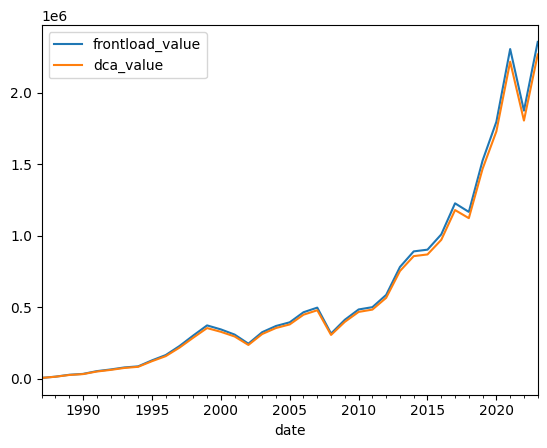

In [23]:
year_end = merged.index.month == 12
results = merged.loc[year_end][['frontload_value', 'dca_value']]
results.plot()

In [24]:
add_commas = lambda x: "{:,}".format(int(x))

In [25]:
# https://finance.yahoo.com/quote/%5EGSPC/history/
# https://dqydj.com/historical-401k-contribution-limit/

cleaned = results.map(add_commas)
cleaned.index = cleaned.index.year

print(cleaned.to_markdown())

|   date | frontload_value   | dca_value   |
|-------:|:------------------|:------------|
|   1987 | 6,310             | 6,116       |
|   1988 | 14,993            | 14,457      |
|   1989 | 28,140            | 26,700      |
|   1990 | 34,301            | 32,891      |
|   1991 | 53,602            | 50,828      |
|   1992 | 65,298            | 62,219      |
|   1993 | 79,466            | 75,864      |
|   1994 | 87,054            | 83,914      |
|   1995 | 128,847           | 123,016     |
|   1996 | 166,020           | 158,403     |
|   1997 | 229,227           | 218,123     |
|   1998 | 302,899           | 287,646     |
|   1999 | 373,525           | 354,875     |
|   2000 | 345,594           | 328,676     |
|   2001 | 309,344           | 296,029     |
|   2002 | 245,626           | 236,766     |
|   2003 | 326,016           | 313,117     |
|   2004 | 369,264           | 355,181     |
|   2005 | 395,140           | 380,317     |
|   2006 | 465,576           | 448,275     |
|   2007 |

In [26]:
print(start, end)
last = results[['frontload_value', 'dca_value']].iloc[-1]
last['frontload_value'] / last['dca_value']

1987 2023


1.0385806402888802